In [1]:
import numpy as np
import pandas as pd
import numpy.linalg as LA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import *

# Читаем и раскладываем данные, чтобы потом было удобно работать

In [2]:
dataTable = np.genfromtxt('p2.csv', delimiter=' ', dtype=np.float64)
dataTable = np.delete(dataTable, [2, 3], axis=1)

In [3]:
x = np.unique(dataTable[:, 0])

In [4]:
y = np.flip(np.unique(dataTable[:, 1]))

In [5]:
xx, yy = np.meshgrid(x, y)


In [6]:
zz = dataTable[:,2].reshape(40,40)

## Визуально красиво, за это можно накинуть балл

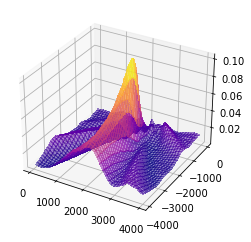

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, zz, cmap="plasma", linewidth=0, antialiased=False, alpha=0.5)
plt.show()

In [8]:
dataTable.shape

(1600, 3)

## Перебор

In [9]:
def enumerationMethod(table):
  max = table[0]
  for row in table:
    if row[2] > max[2]:
      max = row

  print('N:', table.shape[0])
  
  return max

In [10]:
print(enumerationMethod(dataTable))

N: 1600
[ 2.05000e+03 -1.25000e+03  1.03408e-01]


## Шаблонный метод

In [11]:
def templateMethod(xx, yy, zz, len):
  len = len
  N = 0
  def buildCube(center, len):
    nonlocal N
    N += 4
    point1 = np.array([max(0, center[0] - len), max(0, center[1] - len)], dtype=np.int16)
    point1 = np.append(point1, [zz[point1[0]][point1[1]]])

    point2 = np.array([max(0, center[0] - len), min(zz.shape[0] - 1, center[1] + len)], dtype=np.int16)
    point2 = np.append(point2, [zz[point2[0]][point2[1]]])

    point3 = np.array([min(zz.shape[0] - 1, center[0] + len), max(0, center[1] - len)], dtype=np.int16)
    point3 = np.append(point3, [zz[point3[0]][point3[1]]])

    point4 = np.array([min(zz.shape[0] - 1, center[0] + len), min(zz.shape[0] - 1, center[1] + len)], dtype=np.int16)
    point4 = np.append(point4, [zz[point4[0]][point4[1]]])

    return np.array([point1, point2, point3, point4])

  centerPoint = np.random.randint(low=0, high=xx.shape[0], size=2)
  centerPoint = np.append(centerPoint, [zz[centerPoint[0]][centerPoint[1]]])
  N += 1
  square = buildCube(centerPoint, len)
  square = square[square[:, -1].argsort()[::-1]]
  
  while len != 0:
    if centerPoint[-1] < square[0][-1]:
      centerPoint = square[0]
    else:
      # len = len // 2
      len = len - 1
    square = buildCube(centerPoint, len)
    square = square[square[:, -1].argsort()[::-1]]

  # print('N:', N)

  return xx[int(centerPoint[0])][int(centerPoint[1])], yy[int(centerPoint[0])][int(centerPoint[1])], centerPoint[-1], N



In [12]:
templateMethod(xx, yy, zz, 10)

(2050.0, -1850.0, 0.0826364, 85)

## Заводим табличку, чтобы производить исследования работы алгоритмов

In [13]:
search = pd.DataFrame(columns=['len', 'Mean N', 'Mean Error'])

In [14]:
trueVal = 1.03408e-01
for tmp in [3, 5, 8, 10, 12, 15, 18, 20, 22]:
    res = []
    Ns = []
    for _ in range(10):
        _, _, resVal, nVal = templateMethod(xx, yy, zz, tmp)
        res.append(resVal)
        Ns.append(nVal)
    search = pd.concat(
        [search, pd.Series(
            {'len': tmp,'Mean N': np.mean(Ns),
             'Mean Error': (trueVal - np.mean(res)) / trueVal}).to_frame().T],
        ignore_index=True)


In [15]:
search.sort_values(["Mean Error"], ascending=[True]).head(30)

,len,Mean N,Mean Error
7,20.0,120.2,0.190134
3,10.0,81.4,0.201201
6,18.0,106.6,0.203988
5,15.0,106.6,0.205064
4,12.0,88.6,0.207309
1,5.0,46.6,0.220594
8,22.0,138.2,0.247059
2,8.0,62.2,0.258706
0,3.0,28.2,0.436727


## Случайный поиск

In [17]:
def randomSearch(xx, yy, zz, len, M):
  N = 1
  centerPoint = np.random.randint(low=0, high=zz.shape[0], size=2)

  while len != 0:
    counter = 1
    while counter < M:
      N += 1
      newPoint = centerPoint + np.random.randint(low=-len, high=len, size=2)
      newPoint = np.array([max(0, min(zz.shape[0] - 1, newPoint[0])), max(0, min(zz.shape[0] - 1, newPoint[1]))], dtype=np.int16)
      if zz[newPoint[0]][newPoint[1]] < zz[centerPoint[0]][centerPoint[1]]:
        counter += 1
        continue
        
      centerPoint = newPoint
      break
    # len = len // 2
    len = len - 1
  
  # print('N:', N)

  return xx[centerPoint[0]][centerPoint[1]], yy[centerPoint[0]][centerPoint[1]], zz[centerPoint[0]][centerPoint[1]], N

In [18]:
randomSearch(xx, yy, zz, 15, 10)

(450.0, -2250.0, 0.0195112, 106)

In [19]:
search = pd.DataFrame(columns=['len', 'try', 'Mean N', 'Mean Error'])

In [20]:
trueVal = 1.03408e-01
for tmp in [3, 5, 8, 10, 12, 15, 18, 20, 22]:
    for M in [5, 10, 20 ,30]:
        res = []
        Ns = []
        for _ in range(10):
            _, _, resVal, nVal = randomSearch(xx, yy, zz, tmp, M)
            res.append(resVal)
            Ns.append(nVal)
        search = pd.concat(
            [search, pd.Series(
                {'len': tmp,'try': M,'Mean N': np.mean(Ns),
                 'Mean Error': (trueVal - np.mean(res)) / trueVal}).to_frame().T],
            ignore_index=True)


In [21]:
search.sort_values(["Mean Error"], ascending=[True]).head(30)

,len,try,Mean N,Mean Error
23,15.0,30.0,246.4,1.342042e-16
27,18.0,30.0,308.3,8.277890e-04
26,18.0,20.0,203.0,1.655578e-03
30,20.0,20.0,270.6,1.655578e-03
35,22.0,30.0,438.7,1.655578e-03
33,22.0,10.0,159.4,8.800190e-03
31,20.0,30.0,345.3,8.195962e-02
34,22.0,20.0,264.1,8.314821e-02
25,18.0,10.0,111.3,9.132069e-02
24,18.0,5.0,60.5,1.125959e-01


## Генетический алгоритм

In [22]:
def genetic(popNumber, chanceToCrossing, chanceToMut,epochNumber, zz):
  popul = []
  N = popNumber
  for _ in range(popNumber):
    popul.append(np.random.randint(low=0, high=zz.shape[0], size=2))
    counter = 1

  
  while counter < epochNumber:
    newPoints = crossing(popul, chanceToCrossing)
    mutate(newPoints, chanceToMut)

    N += len(newPoints)

    popul = [*popul, *newPoints]
    popul = sorted(popul, key=lambda x: zz[x[0]][x[1]], reverse=True)[:popNumber]
    counter += 1

  # print('N:', N)
  
  return popul[0][0], popul[0][1], zz[popul[0][0]][popul[0][1]], N

def crossing(population, chanceToCrossing):
  newPoints = []
  for i in range(len(population)):
    for j in range(i + 1, len(population)):
      if np.random.uniform() > chanceToCrossing:
        number = np.random.randint(low=0, high=1)
        newPoints.append(np.array([population[i][number],population[j][1 - number]]))
  return newPoints

def mutate(population, chanceToMut):
  for i in range(len(population)):
    if np.random.uniform() > chanceToMut:
      mut = np.random.randint(low=-zz.shape[0], high=zz.shape[0], size=2)

      if np.random.uniform() > 0.5:
        mut[0] = 0
      else:
        mut[1] = 0
      
      tmp = population[i] + mut
      population[i] = np.array([max(0, min(zz.shape[0] - 1, tmp[0])), max(0, min(zz.shape[0] - 1, tmp[1]))])


In [23]:
genetic(4, .3, .2, 50, zz)

(11, 20, 0.102552, 219)

In [24]:
search = pd.DataFrame(columns=['popNumber', 'chanceToCrossing', 'chanceToMut', 'epochNumber', 'Mean N', 'Mean Error'])

In [25]:
trueVal = 1.03408e-01
for popNumber in [3, 5, 8, 10]:
  for chanceToCrossing in [.3, .5, .7]:
    for chanceToMut in [.3, .5, .7]:
      for epochNumber in [10, 15, 20, 50]:
        res = []
        Ns = []
        for _ in range(10):
          _, _, resVal, nVal = genetic(popNumber, chanceToCrossing, chanceToMut, epochNumber, zz)
          res.append(resVal)
          Ns.append(nVal)
        search = pd.concat([search, pd.Series({'popNumber': popNumber, 'chanceToCrossing': chanceToCrossing, 'chanceToMut': chanceToMut, 'epochNumber': epochNumber, 'Mean N': np.mean(Ns), 'Mean Error': (trueVal - np.mean(res)) / trueVal}).to_frame().T], ignore_index=True)

In [26]:
search.sort_values(["Mean Error"], ascending=[True]).head(30)

,popNumber,chanceToCrossing,chanceToMut,epochNumber,Mean N,Mean Error
75,8.0,0.3,0.3,50.0,963.5,0.003431
111,10.0,0.3,0.3,50.0,1552.7,0.005958
119,10.0,0.3,0.7,50.0,1558.4,0.007972
79,8.0,0.3,0.5,50.0,961.5,0.011403
135,10.0,0.7,0.3,50.0,661.9,0.013572
123,10.0,0.5,0.3,50.0,1118.3,0.015093
131,10.0,0.5,0.7,50.0,1106.3,0.020066
127,10.0,0.5,0.5,50.0,1124.5,0.020685
115,10.0,0.3,0.5,50.0,1555.4,0.034448
83,8.0,0.3,0.7,50.0,961.0,0.036953


## Метод имитации отжига

In [78]:
a = np.random.randint(low=0, high=zz.shape[0], size=2, dtype=np.int32)

In [79]:
print(a)

[ 9 33]


In [93]:
zz.shape

(40, 40)

In [217]:
def simulatedAnnealing(coolDownRate, startTemp, stepSize, maxIterations, zz):
  point = np.random.randint(low=0, high=zz.shape[0], size=2)
  pointCost = getCost(point, zz)
  T = startTemp
  best = {
    "coords": point,
    "cost": pointCost
  }
  nT = T
  for n in range(1, maxIterations + 1):
    # nT = T * exp(-coolDownRate / n)
    nT *= 0.99
    newPoint = getNeigbhor(point, stepSize, nT, T)
    newPointCost = getCost(newPoint, zz)
    if shouldAccept(newPointCost, pointCost, nT):
      point = newPoint
      pointCost = newPointCost
    if newPointCost > best["cost"]:
      best["coords"] = newPoint
      best["cost"] = newPointCost
  return best

def getCost(coords, zz):
  return zz[int(coords[0])][int(coords[1])]

def getNeigbhor(coords, stepSize, temp, startTemp):
  # print(stepSize * temp // startTemp)
  
  newCoords = coords + np.random.randint(low=-1, high=1, size=2) * stepSize * temp // startTemp
  newCoords[0] = newCoords[0] if newCoords[0] >= 0 else 0 if newCoords[0] <= 40 else 40
  newCoords[1] = newCoords[1] if newCoords[1] >= 0 else 0 if newCoords[1] <= 40 else 40
  return newCoords

def shouldAccept(newCost, oldCost, temp):
  # print(exp((newCost - oldCost) / temp))
  if newCost >= oldCost:
    return True
  try:
    return exp((newCost - oldCost) / temp) > np.random.rand()
  except OverflowError:
    return 1


In [222]:
a = simulatedAnnealing(1, 1e-3, 12, 10000, zz)
print(a)

{'coords': array([10, 15]), 'cost': 0.0206034}


In [232]:
search = pd.DataFrame(columns=['coolDownRate', 'startTemp', 'stepSize', 'maxIterations', 'Mean N', 'Mean Error'])

In [372]:
trueVal = 1.03408e-01
for coolDownRate in [1, 2, 5, ]:
  for startTemp in [40, 60, 80, 120]:
    for stepSize in [1, 2, 3]:
      for maxIterations in [100*i for i in range(1, 30, 5)]:
        res = []
        Ns = []
        for _ in range(10):
          best = simulatedAnnealing(coolDownRate, startTemp, stepSize, maxIterations, zz)
          res.append(best["cost"])
          Ns.append(maxIterations)
        search = pd.concat([search, pd.Series({'coolDownRate': coolDownRate, 'startTemp': startTemp, 'stepSize': stepSize, 'maxIterations': maxIterations, 'Mean N': np.mean(Ns), 'Mean Error': (trueVal - np.mean(res)) / trueVal}).to_frame().T], ignore_index=True)

In [374]:
search.sort_values(["Mean Error"], ascending=[True]).head(30)

,coolDownRate,startTemp,stepSize,maxIterations,Mean N,Mean Error
75,2.0,40.0,1.0,1600.0,1600.0,0.490472
111,2.0,80.0,1.0,1600.0,1600.0,0.523254
57,1.0,120.0,1.0,1600.0,1600.0,0.533807
22,1.0,60.0,1.0,2100.0,2100.0,0.541453
129,2.0,120.0,1.0,1600.0,1600.0,0.543134
56,1.0,120.0,1.0,1100.0,1100.0,0.548140
7,1.0,40.0,2.0,600.0,600.0,0.561690
20,1.0,60.0,1.0,1100.0,1100.0,0.562215
21,1.0,60.0,1.0,1600.0,1600.0,0.571134
46,1.0,80.0,2.0,2100.0,2100.0,0.571137


In [27]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(xx, yy, zz, cmap="plasma", linewidth=0, antialiased=False, alpha=0.5)
# for ii in range(0,360,1):
#         ax.view_init(elev=10., azim=ii)
#         plt.savefig("pngg/movie%d.png" % ii)

In [28]:
# import imageio
# images = []
# filenames = [f'pngg/movie{i}.png' for i in range(0, 360, 1)]
# for filename in filenames:
#     images.append(imageio.imread(filename))
# imageio.mimsave('movie.gif', images)